##### Author contributions
Please fill out for each of the following parts who contributed to what:
- Conceived ideas: Everybody
- Performed math exercises: Everybody
- Performed programming exercises: Everybody
- Contributed to the overall final assignment: Everybody

Everybody did the assignment themselves and we voted afterwards for the one version to submit.

# Chapter 6
## Deep learning


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Brightspace before the deadline (see Brightspace).

Learning goals:
1. Get familiar with a state-of-the-art module for deep learning
1. Implement and run a multilayer neural network in PyTorch
1. Understand convolution
1. Implement and run a convolutional neural network in PyTorch

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal as ss
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

It might occur that the above imports throw an error, saying `torch` is an unknown module. If so, you have not yet installed `pytorch` properly. Do so by opening a terminal and installing it by calling `conda install pytorch torchvision -c pytorch` (i.e., see https://pytorch.org/get-started/locally/).

When working on a state-of-the-art neural network project you will rely on one of the various neural network frameworks that are available, instead of implementing core functionality by yourself. In this exercise you will work on implementing an MLP and a CNN in the PyTorch framework. 

To get familiar with PyTorch, read the tutorial at https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html. It is a good introduction to PyTorch including setting up data, defining a model, and training a model. 

### Exercise 1: MNIST data (1 point)
We will use the MNIST dataset (handwritten digets) for this assignment. The dataset is a very standard and commonly used benchmark dataset. In this assignment, we will only work with a training and validation dataset. Normally, one would also have a testing dataset, but we will ignore this in this assignment.
1. Load the *MNIST* dataset. Use a training and a validation dataset.
1. Define training and validation data iterators and use a specific batchsize.
1. Inspect the training and validation data by printing (1) the amount of samples in each set and (2) the shape of a data sample.
1. Inspect the training and validation data by plotting some samples (as images).

### Solution 1

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Size of the training data set 60000
Shape of a training data sample [1, 28, 28]


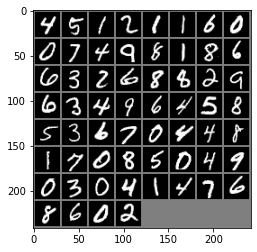

In [ ]:
# Answers are adapted instructions from the tutorial linked above.
# 1. Load the MNIST Dataset (with normalization, as seen in the tutorial)

transform = transforms.Compose(
    [transforms.ToTensor()
    ,transforms.Normalize((0.5,),(0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# 2. Define training and validation data iterators
trainloader = torch.utils.data.DataLoader(trainset, batch_size=60,
                                          shuffle=True, num_workers=2)
train_iter = iter(trainloader)

testloader = torch.utils.data.DataLoader(testset, batch_size=60,
                                         shuffle=False, num_workers=2)
test_iter = iter(testloader)

# 3. Inspect the data by printing the amount of samples in each set and the shape of a data sample

print("Size of the training data set", (trainset.data.size()[0]))

print("Shape of a training data sample", (list(trainset.__getitem__(0)[0].size())))

# 4. Plot some random images

# get some random training images
images, labels = train_iter.next()

# show sample images

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [ ]:
print(trainset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


### Exercise 2: Training a model (3 points)
Define a function `train_model` with input arguments `model`, `train_data`, `valid_data`, `optimizer`, `criterion`, and `n_epochs`, and output arguments `model`, `train_loss`, `valid_loss`, `train_accuracy`, `valid_accuracy`. We will use this function to train both a MLP as well as a CNN. It therefore has to be generic to any type of model, optimizer, or loss function. The function:
1. Loops over `n_epoch` epochs.
1. Loops over minibatches of both training data `train_data` as well as validation data `valid_data`.
1. Trains the model using the loss function defined by `criterion` and optimizer `optimizer` using the training data.
1. Computes and saves losses for both training and validation data per epoch in `train_loss` and `valid_loss`.
1. Computes and saves accuracies for both training and validation data per epoch in `train_accuracy` and `valid_accuracy`.

### Solution 2

In [ ]:
def train_model(model, train_data, valid_data, optimizer, criterion, n_epochs):
  train_loss = np.zeros((n_epochs), dtype=np.float32)
  valid_loss = np.zeros((n_epochs), dtype=np.float32)
  train_accuracy = np.zeros((n_epochs), dtype=np.float32)
  valid_accuracy = np.zeros((n_epochs), dtype=np.float32)
  start = 0

  for epoch in range(n_epochs):
    train_total = 0
    val_total = 0
    start = time.time()

    #validation loop
    with torch.no_grad():
      for val_idx, minibatch in enumerate(valid_data, 0):
        val_images, val_labels = minibatch[0].to(device), minibatch[1].to(device)
        val_outputs = model(val_images)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_loss = criterion(val_outputs, val_labels)
        valid_loss[epoch]+=val_loss.item()
        val_total += val_labels.size(0)
        valid_accuracy[epoch] += (val_predicted == val_labels).sum().item()

    #training loop
    for train_idx, minibatch in enumerate(train_data, 0):
      images, labels = minibatch[0].to(device), minibatch[1].to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      _, predicted = torch.max(outputs.data, 1)
      train_loss[epoch]+=loss.item()
      train_total += labels.size(0)
      train_accuracy[epoch] += (predicted == labels).sum().item()
      
    train_loss[epoch] = train_loss[epoch] / train_idx
    train_accuracy[epoch] = train_accuracy[epoch] / train_total
    valid_loss[epoch] = valid_loss[epoch] / val_idx
    valid_accuracy[epoch] = valid_accuracy[epoch] / val_total

    print("Epoch: ", epoch, " t_loss: ", train_loss[epoch], " v_loss: ", valid_loss[epoch], " train_acc: ", train_accuracy[epoch], " valid_acc: ", valid_accuracy[epoch], " t: ", time.time()-start)
    start = 0

  return model, train_loss, valid_loss, train_accuracy, valid_accuracy

### Exercise 3: Setup an MLP (1 point)


As a first model, setup a multilayer perceptron:
1. with two linear (i.e., fully connected) weight layers
1. with a hidden layer of 16 ReLU units

### Solution 3

In [ ]:
from collections import OrderedDict

mlp = nn.Sequential(OrderedDict([
          ('flatten', nn.Flatten(start_dim=1)),
          ('fc1', nn.Linear(28*28,16)),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(16,10)),
          ('sm', nn.LogSoftmax(dim=1))
        ]))

torch.nn.init.xavier_uniform_(mlp.fc1.weight)
torch.nn.init.xavier_uniform_(mlp.fc2.weight)
pass

### Exercise 4: Train the MLP (1 point) 
Train the MLP using the MNIST dataset:
1. As optimizer use SGD with a learning rate of 0.001 and momentum of 0.9.
1. As loss function use the cross-entropy loss.
1. Train the MLP in 20 epochs.
1. Plot the training and validation losses as a function of epochs.
1. Plot the training and validation accuracies as a function of epochs.

### Solution 4

In [ ]:
import time
print(time.time())

1588581027.82255


Epoch:  0  t_loss:  0.7818685  v_loss:  2.8134377  train_acc:  0.76411664  valid_acc:  0.0784  t:  11.342702388763428
Epoch:  1  t_loss:  0.3776364  v_loss:  0.41440085  train_acc:  0.89061666  valid_acc:  0.8811  t:  11.047768354415894
Epoch:  2  t_loss:  0.32920188  v_loss:  0.3327577  train_acc:  0.90535  valid_acc:  0.9066  t:  11.047797918319702
Epoch:  3  t_loss:  0.3047818  v_loss:  0.3040026  train_acc:  0.91211665  valid_acc:  0.9125  t:  11.139619588851929
Epoch:  4  t_loss:  0.2872212  v_loss:  0.28677917  train_acc:  0.9180833  valid_acc:  0.9187  t:  11.051536321640015
Epoch:  5  t_loss:  0.27458894  v_loss:  0.27568537  train_acc:  0.9216833  valid_acc:  0.9213  t:  11.096736669540405
Epoch:  6  t_loss:  0.26212326  v_loss:  0.27034143  train_acc:  0.9256833  valid_acc:  0.923  t:  11.002769947052002
Epoch:  7  t_loss:  0.25167724  v_loss:  0.25386858  train_acc:  0.9288667  valid_acc:  0.9278  t:  10.9446439743042
Epoch:  8  t_loss:  0.24334562  v_loss:  0.24403533  trai

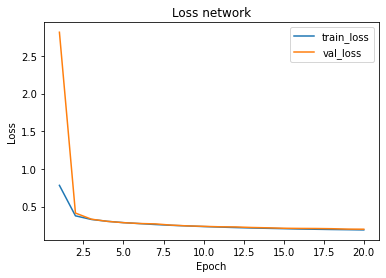

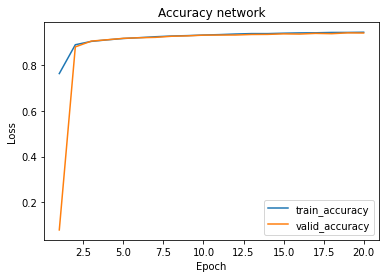

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp.to(device)

model, train_loss, val_loss, train_accuracy, valid_accuracy = train_model(mlp, trainloader, testloader, optimizer, criterion, n_epochs=20)

# Plot losses
plt.plot(range(1,train_loss.shape[0]+1),train_loss)
plt.plot(range(1,val_loss.shape[0]+1),val_loss, label='line 1')
plt.legend(('train_loss', 'val_loss'), loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss network')
plt.show()

plt.plot(range(1,train_accuracy.shape[0]+1),train_accuracy)
plt.plot(range(1,valid_accuracy.shape[0]+1),valid_accuracy, label='line 1')
plt.legend(('train_accuracy', 'valid_accuracy'), loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Accuracy network')
plt.show()

### Exercise 5: Visualize the weights (0.5 points)
The model's weights in a particular layer that the MLP has learned can be found in `model_name.layer_name.weight.data`. Plot the weights of the 16 ReLU units as 2D images.

### Solution 5

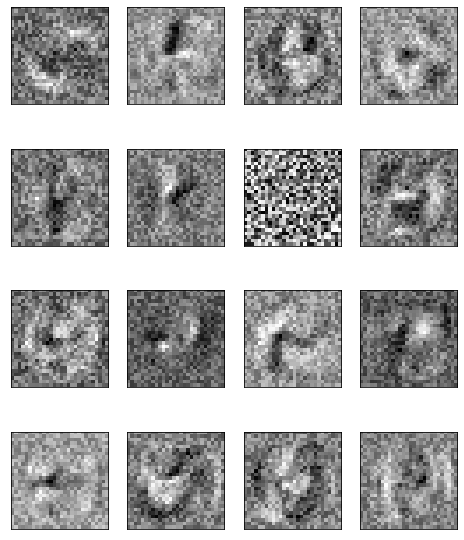

In [ ]:
W2 = model.fc1.weight.data.cpu().numpy()
n_hidden = W2.shape[0]

plt.figure(figsize=([8,10]))
for i in range(n_hidden):
    plt.subplot(4,4,i+1)
    fig = plt.imshow(W2[i, :].reshape([28,28]).T, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

### Exercise 6: Convolution with hand-made kernels (1 point)
In convolutional neural networks we use a mathematical operator between two functions $f$ and $g$ called [*convolution*](https://en.wikipedia.org/wiki/Convolution). In terms of images, one could intuitively think of $f$ as an image, and $g$ as a filter kernel (i.e., a receptive field). For images we need to use 2D convolution: 

$$f(x, y) \ast g(x, y) = \sum^N_{i=-N}\sum^N_{j=-N} f(x, y)g(x-i, y-j)$$

Intuitively, the kernel $g$ is applied on all spatial locations of $f$. You could think of $g$ as having weights that represent how it singles out local input. Usually there are various of these filter kernels $g$, scanning the image for many possible features. 

In this exercise you will perform a simple convolution on one image.
1. Make four $3 \times 3$ kernels. They should represent horizontal, vertical, and the two diagonal line feature detectors.
1. Plot these kernels.
1. Apply the kernels to the image, e.g. by using `convolve2d` from `scipy`.
1. Plot the resulting feature activity map for each of the kernels. 

### Solution 6

In [ ]:
image = train_iter.next()[0][0].reshape((28, 28))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


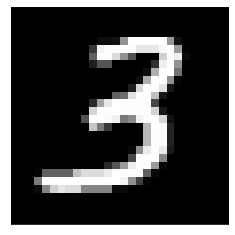

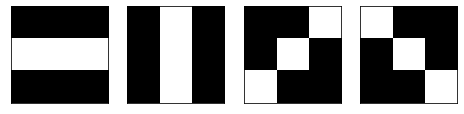

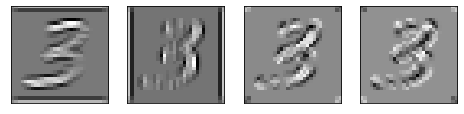

In [ ]:
# The image
#image = train_iter.next()[0][0].reshape((28, 28))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray")
ax.set_xticks([], []) ; ax.set_yticks([], [])

# 1. Create kernels
horizontal      = [ [-1.0, -1.0, -1.0], 
                    [2.00, 2.00, 2.00], 
                    [-1.0, -1.0, -1.0] ]
vertical        = [ [-1.0, 2.00, -1.0], 
                    [-1.0, 2.00, -1.0], 
                    [-1.0, 2.00, -1.0] ]
diag1           = [ [-1.0, -1.0, 2.00], 
                    [-1.0, 2.00, -1.0], 
                    [2.00, -1.0, -1.0] ]
diag2           = [ [2.00, -1.0, -1.0], 
                    [-1.0, 2.00, -1.0], 
                    [-1.0, -1.0, 2.00] ]

# 2. Plot kernels
Kernels = np.array([horizontal, vertical, diag1, diag2])
n_hidden = Kernels.shape[0]

plt.figure(figsize=([8,10]))
for i in range(n_hidden):
    plt.subplot(1,4,i+1)
    fig = plt.imshow(Kernels[i, :].reshape([3,3]), cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
# 3. Convolve the image with the kernels and show the feature maps

plt.figure(figsize=([8,10]))
for i in range(n_hidden):
    convolvo = ss.convolve2d(image, Kernels[i])
    plt.subplot(1,4,i+1)
    fig = plt.imshow(convolvo.reshape([30,30]), cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

### Exercise 7: Setup a CNN (1 points)
As a second model, setup a CNN with:
1. One convolutional layer and one linear (i.e., fully connected) weight layer.
1. In the convolutional layer, use $8$ kernels of size $3\times3$ and stride $1$.
1. ReLU units in the hidden layer.
1. Max pooling with kernels of size $2\times2$ and stride $2$.

### Solution 7

In [ ]:
cnn = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1, 8, kernel_size=3, stride=1)),
          ('relu1', nn.ReLU()),
          ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
          ('flatten', nn.Flatten(start_dim=1)),
          ('fc1', nn.Linear(1352,10)),
          ('sm', nn.LogSoftmax(dim=1))
        ]))

torch.nn.init.xavier_uniform_(cnn.conv1.weight)
torch.nn.init.xavier_uniform_(mlp.fc1.weight)
pass

### Exercise 8: Train the CNN (1 point) 
Train the CNN using the MNIST dataset:
1. As optimizer use SGD with a learning rate of 0.001 and momentum of 0.9.
1. As loss function use the cross-entropy loss.
1. Train the CNN in 20 epochs.
1. Plot the training and validation losses as a function of epochs.
1. Plot the training and validation accuracies as a function of epochs.

### Solution 8

Epoch:  0  t_loss:  0.66706425  v_loss:  2.3487055  train_acc:  0.8264  valid_acc:  0.0654  t:  10.914309024810791
Epoch:  1  t_loss:  0.26342314  v_loss:  0.28666815  train_acc:  0.92335  valid_acc:  0.9204  t:  10.879433155059814
Epoch:  2  t_loss:  0.21087535  v_loss:  0.21255693  train_acc:  0.93941665  valid_acc:  0.9403  t:  10.884166479110718
Epoch:  3  t_loss:  0.18035188  v_loss:  0.18327007  train_acc:  0.94893336  valid_acc:  0.9475  t:  10.90248966217041
Epoch:  4  t_loss:  0.15930346  v_loss:  0.16121976  train_acc:  0.9548  valid_acc:  0.954  t:  10.91062593460083
Epoch:  5  t_loss:  0.14453264  v_loss:  0.14754994  train_acc:  0.95845  valid_acc:  0.9572  t:  10.946712255477905
Epoch:  6  t_loss:  0.13234235  v_loss:  0.13608997  train_acc:  0.9626  valid_acc:  0.961  t:  10.888416051864624
Epoch:  7  t_loss:  0.1241379  v_loss:  0.12449284  train_acc:  0.96485  valid_acc:  0.9653  t:  10.737014532089233
Epoch:  8  t_loss:  0.11740108  v_loss:  0.11805394  train_acc:  0.

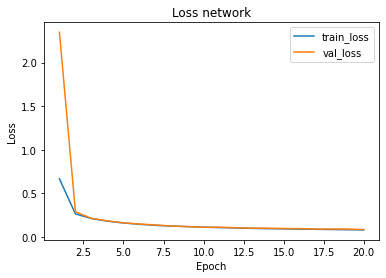

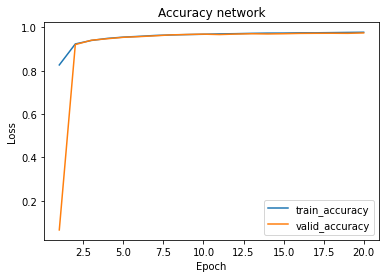

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)

model, train_loss, val_loss, train_accuracy, valid_accuracy = train_model(cnn, trainloader, testloader, optimizer, criterion, n_epochs=20)

# Plot losses
plt.plot(range(1,train_loss.shape[0]+1),train_loss)
plt.plot(range(1,val_loss.shape[0]+1),val_loss, label='line 1')
plt.legend(('train_loss', 'val_loss'), loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss network')
plt.show()

plt.plot(range(1,train_accuracy.shape[0]+1),train_accuracy)
plt.plot(range(1,valid_accuracy.shape[0]+1),valid_accuracy, label='line 1')
plt.legend(('train_accuracy', 'valid_accuracy'), loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Accuracy network')
plt.show()

### Exercise 9: Visualize the weights (0.5 points)
The model's weights in the convolutional layer that the CNN has learned can be found in `model_name.layer_name.weight.data`. Plot the kernels as images.

Showing what the first weight layer learns is easy. But this task becomes more difficult in higher layers, and is a current area of research. Here is highly recommended reading on what convolutional neural networks learn: 

[Feature visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

[The building blocks of interpretability](https://distill.pub/2018/building-blocks/)

### Solution 9

In [ ]:
print(model[0].weight.detach().shape)

torch.Size([8, 1, 3, 3])


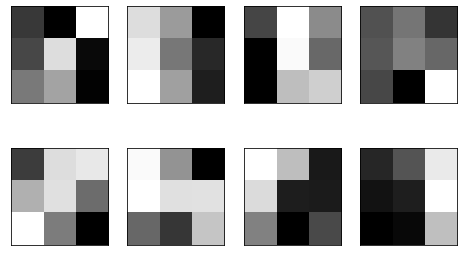

In [ ]:

W2 = model.conv1.weight.data.cpu().numpy()
n_hidden = W2.shape[0]

plt.figure(figsize=([8,10]))
for i in range(n_hidden):
    plt.subplot(4,4,i+1)
    fig = plt.imshow(W2[i, :].reshape([3,3]).T, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

### Exercise 10: Interpretation (2 points)
1. Which of the two models performed better for classifying MNIST digits in this example? Compare speed of training and test set accuracy. 
1. The main difference of the models is the type of the first layer. Why would a convolutional layer lead to the better succes here? 
1. Explain one argument why the convolution operation is biologically plausible and one argument why it is biologically implausible. 

### Solution 10
1. The convolutional network performed alot better. The speed of both networks appears to be comparable, both are reaching good performance within 5 epochs.
1. We have to flatten the input for the fully connected layers, thus we lose spatial information. For convolutional neural networks we train 2d feature maps which incorporate image information
1. The brain processes visual stimuli similar to how feature maps are combined in convolutional networks, which supports the claim that convolution is biologically plausible. 